# kaggle-titanic
kernel by Rasmus N

* goal 1: start learning scikit-learn, pandas and numpy 
* goal 2: score ~ 80 (accuracy)
* goal 3: have fun :)

Inspiration:
    https://www.kaggle.com/erikbruin/titanic-2nd-degree-families-and-majority-voting
    https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling/notebook
    https://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html

TODO:
    - Try more models (ADA, MLP etc)
    - Feature selection based on more classifiers (select union of 15 best per classifier?)
    - Build voting classifier based on iterations as well as different classifiers
    - Plot learning curves

# 1. data prep & analysis

## // data reading

In [8]:
# import packages
import re
import sys
import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV, KFold, cross_val_predict, cross_val_score, learning_curve
from sklearn.metrics import r2_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel



In [9]:
# read data
train_data = pd.read_csv('~/.kaggle/competitions/titanic/train.csv')
test_data = pd.read_csv('~/.kaggle/competitions/titanic/test.csv')

# dataset info
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* 38 percent survived.
* it looks like age is missing in 177 cases (891-714). we have to do something here, for example impute missing values or fill with mean/median etc.

In [10]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
test_data.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


* age is missing here as well
* also Fare is missing once.

In [12]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [73]:
# combine data
combined_data = pd.concat([train_data, test_data])
combined_data = combined_data.reset_index()

## // descripte stats

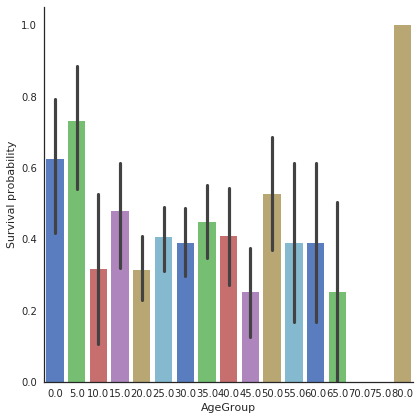

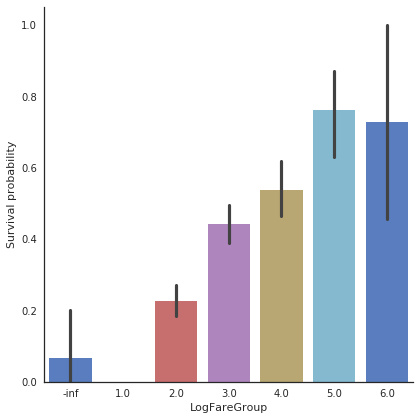

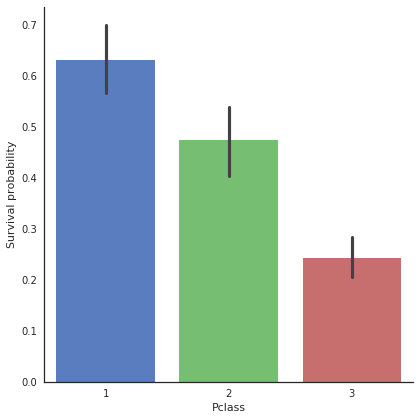

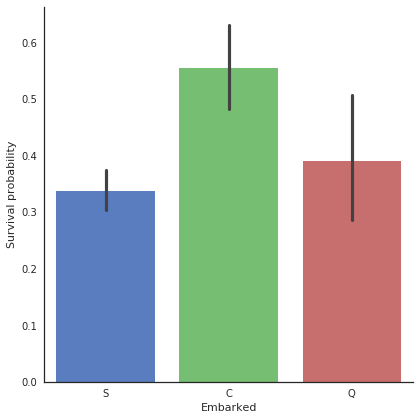

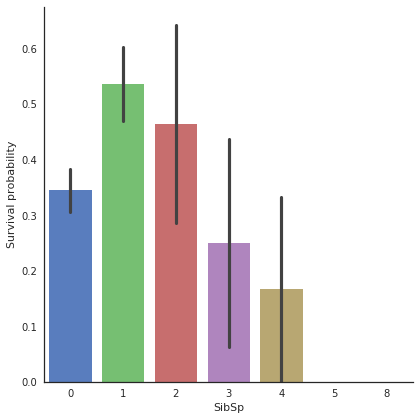

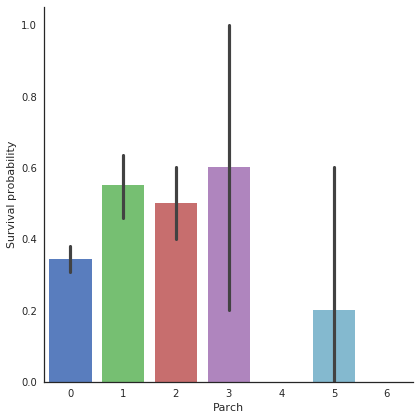

In [74]:
data = combined_data[(combined_data['Age'].notnull()) & (combined_data['Survived'].notnull())][['Age', 'Survived']]
data['AgeGroup'] = (data['Age']/5).round()*5

g = sns.factorplot(x="AgeGroup", y="Survived", data=data, kind="bar", size = 6, palette = "muted")
g.set_ylabels("Survival probability")

data = combined_data[(combined_data['Fare'].notnull()) & (combined_data['Survived'].notnull())][['Fare', 'Survived']]
data['LogFare'] = data['Fare'].apply(np.log)
data['LogFareGroup'] = data['LogFare'].round()

g = sns.factorplot(x="LogFareGroup", y="Survived", data=data, kind="bar", size = 6, palette = "muted")
g.set_ylabels("Survival probability")

data = combined_data[combined_data['Survived'].notnull()]

g = sns.factorplot(x="Pclass", y="Survived", data=data, kind="bar", size = 6, palette = "muted")
g.set_ylabels("Survival probability")

g = sns.factorplot(x="Embarked", y="Survived", data=data, kind="bar", size = 6, palette = "muted")
g.set_ylabels("Survival probability")

g = sns.factorplot(x="SibSp", y="Survived", data=data, kind="bar", size = 6, palette = "muted")
g.set_ylabels("Survival probability")

g = sns.factorplot(x="Parch", y="Survived", data=data, kind="bar", size = 6, palette = "muted")
g.set_ylabels("Survival probability")



## // imputation

      index   Age Cabin Embarked  Fare                Name  Parch  \
1043    152  60.5   NaN        S   NaN  Storey, Mr. Thomas      0   

      PassengerId  Pclass   Sex  SibSp  Survived Ticket  
1043         1044       3  male      0       NaN   3701  
     index   Age Cabin Embarked  Fare  \
61      61  38.0   B28      NaN  80.0   
829    829  62.0   B28      NaN  80.0   

                                          Name  Parch  PassengerId  Pclass  \
61                         Icard, Miss. Amelie      0           62       1   
829  Stone, Mrs. George Nelson (Martha Evelyn)      0          830       1   

        Sex  SibSp  Survived  Ticket  
61   female      0       1.0  113572  
829  female      0       1.0  113572  


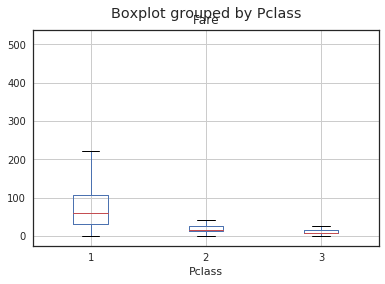

In [75]:
# replace fare
print(combined_data[combined_data['Fare'].isnull()])
combined_data.boxplot(column=['Fare'], by='Pclass')
combined_data.loc[combined_data['PassengerId']==1044, 'Fare'] = combined_data[combined_data['Pclass']==3]['Fare'].median()

# replace embarked
print(combined_data[combined_data['Embarked'].isnull()])
combined_data[combined_data['Cabin']=='B28']
combined_data[combined_data['Ticket']=="113572"]
combined_data[combined_data['Fare']==80]
combined_data[combined_data['Name'].str.contains("Icard")]
combined_data[combined_data['Name'].str.contains("Stone")]

combined_data.Embarked.fillna('S', inplace=True)

Fare was easily replaced with some help from Pclass. Embarked was replaced by most common value though, got no help from other variables. 

# 2. feature engineering 

## // transform class variables

Empty DataFrame
Columns: [pclass_encoded]
Index: []
Empty DataFrame
Columns: [embarked_encoded]
Index: []
Empty DataFrame
Columns: [title_encoded]
Index: []
Empty DataFrame
Columns: [cabin_letter_encoded]
Index: []
Empty DataFrame
Columns: [family_id_encoded]
Index: []
    age  cabin_number  family_size     fare  id  log_fare  \
0  22.0        -999.0            2   7.2500   1  1.981001   
1  38.0          85.0            2  71.2833   2  4.266662   
2  26.0        -999.0            1   7.9250   3  2.070022   
3  35.0         123.0            2  53.1000   4  3.972177   
4  35.0        -999.0            1   8.0500   5  2.085672   

   number_parents_children  number_siblings_spouses  sex_is_male  target  \
0                        0                        1            1       0   
1                        0                        1            0       1   
2                        0                        0            0       1   
3                        0                        1        

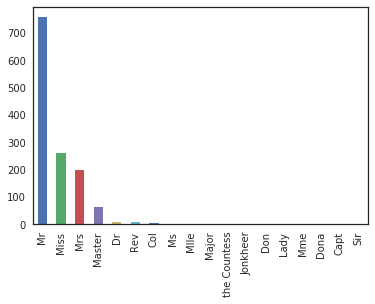

In [76]:
le = LabelEncoder()

# create features
log_fare = combined_data['Fare'].apply(np.log)
family_size = combined_data['SibSp'] + combined_data['Parch'] + 1
cabin_number = combined_data['Cabin'].str.extract('(\d+)', expand=False).fillna(-999)

ticket_is_digit =  combined_data['Ticket'].apply(lambda x: 1 if x.isdigit() else 0)
sex_is_male =  combined_data['Sex'].apply(lambda x: 1 if x == 'male' else 0)

combined_data['title'] = combined_data['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
combined_data['title'].value_counts().plot(kind='bar', stacked=True)
combined_data['title'] = combined_data['title'].apply(lambda x: x if x in ['Mr', 'Mrs', 'Miss', 'Master'] else 'Other')

combined_data['family_id'] = combined_data['Name'].map(lambda name:name.split(',')[0].strip())
combined_data['family_id'] = combined_data['family_id'].str.cat(family_size.astype(str), sep='')
family_count = combined_data.groupby('family_id').PassengerId.count()
family_count = family_count.rename('family_count')
combined_data = combined_data.join(family_count, on=['family_id'])
small_family_indices = (combined_data['family_count'] <= 2)
combined_data.loc[small_family_indices, 'family_id'] = 'SMALL_FAMILY'
combined_data = combined_data.drop('family_count', axis=1)

combined_data['cabin_letter'] = combined_data['Cabin'].str.slice(0, 1)
combined_data['cabin_letter'].fillna('Unknown', inplace=True)

def encode_feature(df, feature, by):
    
    feature_encoded_name = feature.lower() + '_encoded'
    
    stats = combined_data[combined_data[by] != -999].groupby(feature)[by].mean()
    stats = stats.sort_values(ascending=False).to_frame()
    stats = stats.reset_index()
    stats[feature_encoded_name] = stats.index
    stats = stats.drop(by, axis=1)
    stats = stats.set_index(feature)
    
    feature_encoded = df.join(stats, on=feature)[[feature_encoded_name]]
    
    print(feature_encoded[feature_encoded[feature_encoded_name].isnull()])
    
    feature_onehot = pd.get_dummies(feature_encoded[feature_encoded_name])
    feature_onehot.columns = [feature.lower() + '_' + str(x).lower() for x in feature_onehot.columns]
    
    return feature_encoded, feature_onehot

pclass_encoded, pclass_onehot = encode_feature(combined_data, 'Pclass', 'Survived')
embarked_encoded, embarked_onehot = encode_feature(combined_data, 'Embarked', 'Survived')
title_encoded, title_onehot = encode_feature(combined_data, 'title', 'Survived')
cabin_encoded, cabin_onehot = encode_feature(combined_data, 'cabin_letter', 'Survived')
family_encoded, family_onehot = encode_feature(combined_data, 'family_id', 'Survived')

others = pd.DataFrame(data = {
    'id': combined_data['PassengerId'],
    'target': combined_data['Survived'].fillna(-999).astype(int),
    'fare': combined_data['Fare'],
    'log_fare': log_fare,
    'age': combined_data['Age'],
    'number_siblings_spouses': combined_data['SibSp'],
    'number_parents_children': combined_data['Parch'],
    'family_size': family_size,
    'cabin_number': cabin_number.astype(float),
    'sex_is_male': sex_is_male,
    'ticket_is_digit': ticket_is_digit
    })

combined_data = pd.concat(
    [others,
     pclass_encoded, pclass_onehot, embarked_encoded, embarked_onehot,
     title_encoded, title_onehot, cabin_encoded, cabin_onehot,
     family_encoded, family_onehot]
    , axis=1)

print(combined_data.head())
for x in combined_data.columns:
    print(x)

## // binning

In [77]:
def bin_variable(x, y, min_samples_leaf=20, max_leaf_nodes=2):

    clf = DecisionTreeClassifier(criterion = 'entropy', min_samples_leaf=min_samples_leaf, max_leaf_nodes=max_leaf_nodes)
    clf.fit(x.values.reshape(-1,1), y.values)

    lower, higher = x.min(), x.max()
    threshold = clf.tree_.threshold[clf.tree_.threshold>-2].tolist()
    threshold.append(lower)
    threshold.append(higher)
    threshold.sort()

    test = pd.concat([x, y], axis=1)
    test['binned'] = pd.cut(x, threshold, include_lowest=True)

    test.groupby('binned').target.mean().plot(kind='bar', stacked=True)
    plt.show()
    test.groupby('binned').target.count().plot(kind='bar', stacked=True)
    plt.show()
    
    return threshold

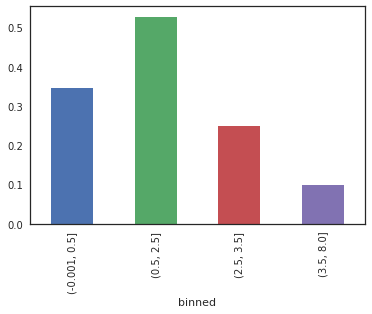

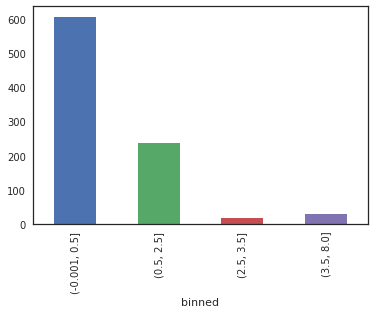

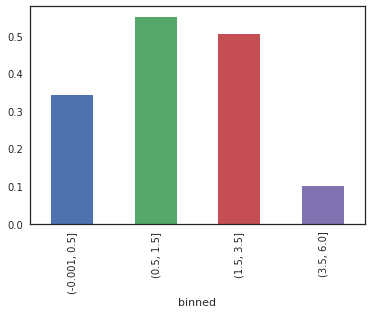

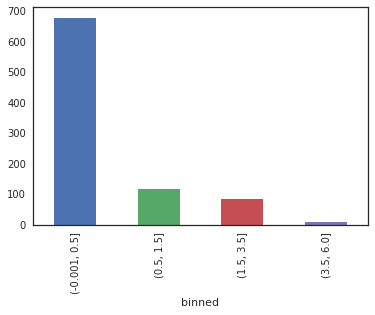

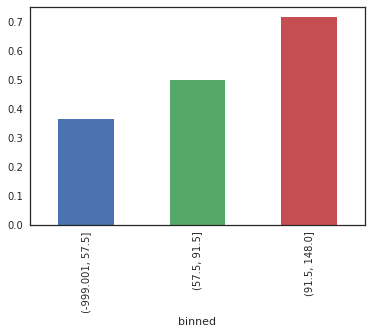

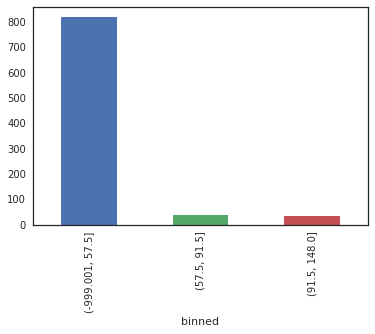

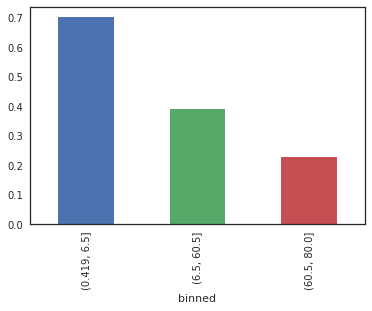

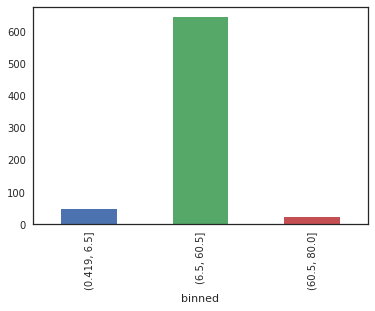

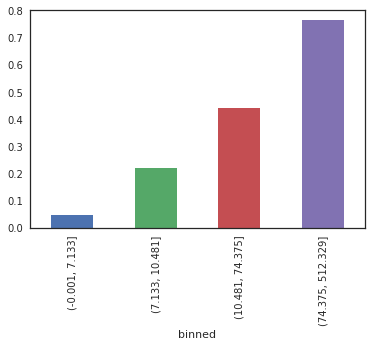

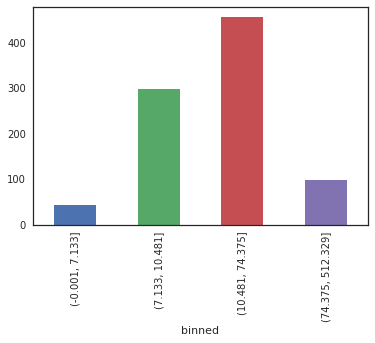

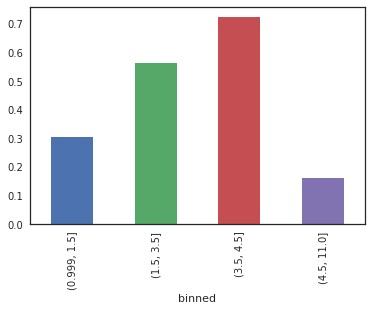

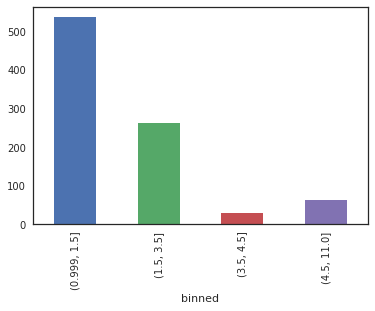

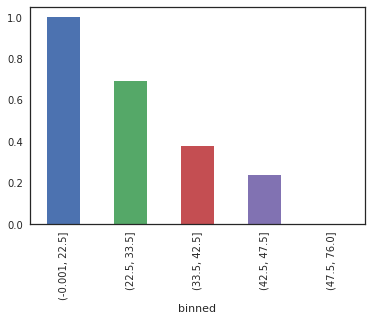

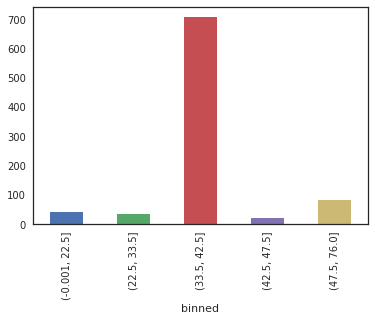

In [78]:
# binning
x_siblings = combined_data[(combined_data['target'] != -999) & (combined_data['number_siblings_spouses'].notnull())]['number_siblings_spouses']
y_siblings = combined_data[(combined_data['target'] != -999) & (combined_data['number_siblings_spouses'].notnull())]['target']

siblings_bins = bin_variable(x_siblings, y_siblings, min_samples_leaf=10, max_leaf_nodes=4)

x_parents = combined_data[(combined_data['target'] != -999) & (combined_data['number_parents_children'].notnull())]['number_parents_children']
y_parents = combined_data[(combined_data['target'] != -999) & (combined_data['number_parents_children'].notnull())]['target']

parents_bins = bin_variable(x_parents, y_parents, min_samples_leaf=10, max_leaf_nodes=4)

x_cabin_number = combined_data[(combined_data['target'] != -999) & (combined_data['cabin_number'].notnull())]['cabin_number']
y_cabin_number = combined_data[(combined_data['target'] != -999) & (combined_data['cabin_number'].notnull())]['target']

cabin_number_bins = bin_variable(x_cabin_number, y_cabin_number, min_samples_leaf=10, max_leaf_nodes=4)

x_age = combined_data[(combined_data['target'] != -999) & (combined_data['age'].notnull())]['age']
y_age = combined_data[(combined_data['target'] != -999) & (combined_data['age'].notnull())]['target']

age_bins = bin_variable(x_age, y_age, min_samples_leaf=20, max_leaf_nodes=3)

x_fare = combined_data[(combined_data['target'] != -999) & (combined_data['fare'].notnull())]['fare']
y_fare = combined_data[(combined_data['target'] != -999) & (combined_data['fare'].notnull())]['target']

fare_bins = bin_variable(x_fare, y_fare, min_samples_leaf=20, max_leaf_nodes=4)

x_family_size = combined_data[(combined_data['target'] != -999) & (combined_data['family_size'].notnull())]['family_size']
y_family_size = combined_data[(combined_data['target'] != -999) & (combined_data['family_size'].notnull())]['target']

family_size_bins = bin_variable(x_family_size, y_family_size, min_samples_leaf=20, max_leaf_nodes=4)

x_family_id = combined_data[(combined_data['target'] != -999) & (combined_data['family_id_encoded'].notnull())]['family_id_encoded']
y_family_id = combined_data[(combined_data['target'] != -999) & (combined_data['family_id_encoded'].notnull())]['target']

family_id_bins = bin_variable(x_family_id, y_family_id, min_samples_leaf=20, max_leaf_nodes=5)

In [95]:
# merge to master dataframe
combined_data['fare_bins'] = pd.cut(combined_data['fare'], fare_bins, include_lowest=True, labels=False).astype(int)
combined_data['family_size_bins'] = pd.cut(combined_data['family_size'], family_size_bins, include_lowest=True, labels=False).astype(int)
combined_data['cabin_number_bins'] = pd.cut(combined_data['cabin_number'], cabin_number_bins, include_lowest=True, labels=False).astype(int)
combined_data['siblings_bins'] = pd.cut(combined_data['number_siblings_spouses'], siblings_bins, include_lowest=True, labels=False).astype(int)
combined_data['parents_bins'] = pd.cut(combined_data['number_parents_children'], parents_bins, include_lowest=True, labels=False).fillna(3).astype(int)
combined_data['family_id_bins'] = pd.cut(combined_data['family_id_encoded'], family_id_bins, include_lowest=True, labels=False).fillna(5).astype(int)

fare_bins_encoded, fare_bins_onehot = encode_feature(combined_data, 'fare_bins', 'target')
family_size_bins_encoded, family_size_bins_onehot = encode_feature(combined_data, 'family_size_bins', 'target')
cabin_number_bins_encoded, cabin_number_bins_onehot = encode_feature(combined_data, 'cabin_number_bins', 'target')
siblings_bins_encoded, siblings_bins_onehot = encode_feature(combined_data, 'siblings_bins', 'target')
parents_bins_encoded, parents_bins_onehot = encode_feature(combined_data, 'parents_bins', 'target')

# >>> to solve: family id 77 has no target
# peobably remove: combined_data[by] != -999] ^up
family_id_bins_encoded, family_id_bins_onehot = encode_feature(combined_data, 'family_id_bins', 'target')

sys.exit()
### <<<



# deal with age later on

combined_data.drop(['fare_bins', 'family_size_bins', 'cabin_number_bins',
                    'siblings_bins', 'parents_bins', 'family_id_bins'], axis=1)

combined_data = pd.concat(
    [combined_data,
     fare_bins_encoded, fare_bins_onehot,
     family_size_bins_encoded, family_size_bins_onehot,
     cabin_number_bins_encoded, cabin_number_bins_onehot,
     siblings_bins_encoded, siblings_bins_onehot,
     parents_bins_encoded, parents_bins_onehot,
     family_id_bins_encoded, family_id_bins_onehot]
     , axis=1)

print(combined_data.head())
for x in combined_data.columns:
    print(x)

      family_id_bins_encoded
1050                     NaN
1172                     NaN
1300                     NaN
target   -999.0
Name: 1050, dtype: float64


SystemExit: 

/home/rasmus/miniconda3/envs/ml/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2971: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## // imputation 2 (age)

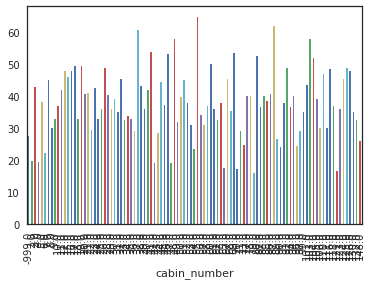

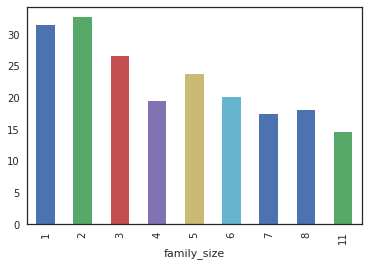

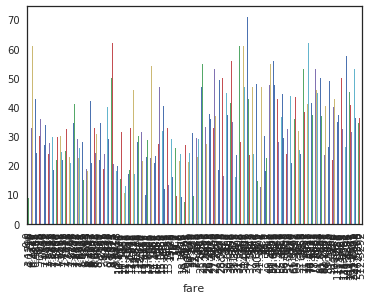

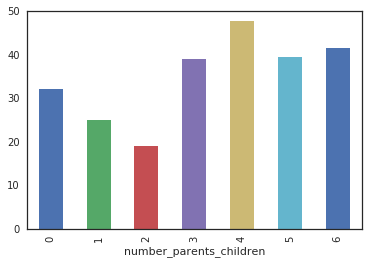

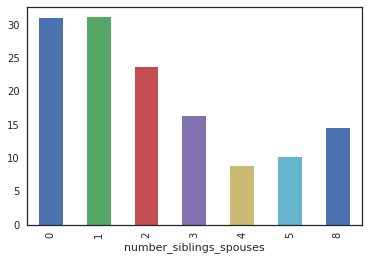

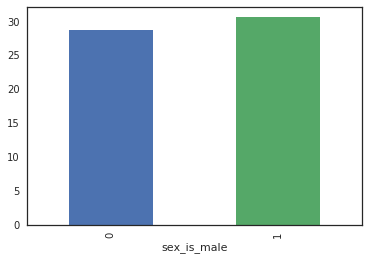

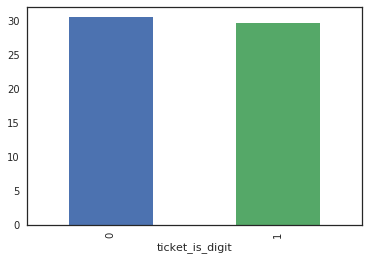

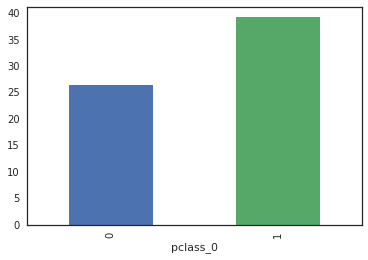

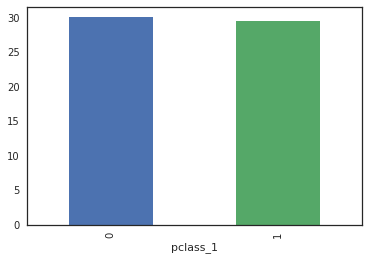

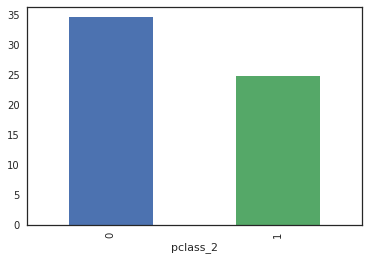

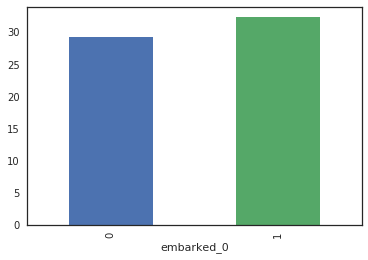

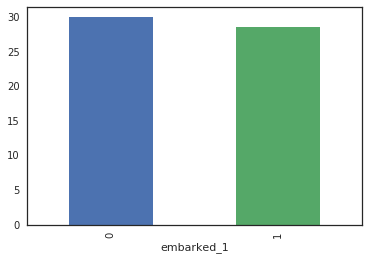

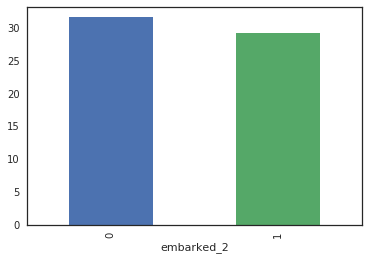

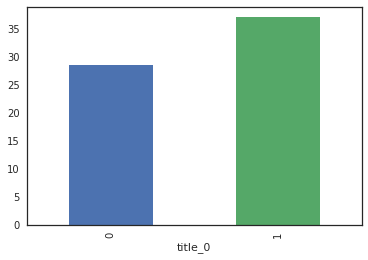

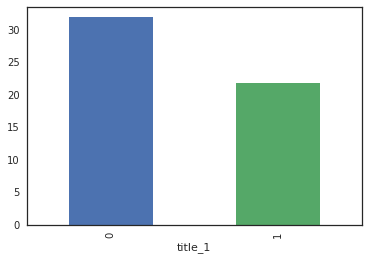

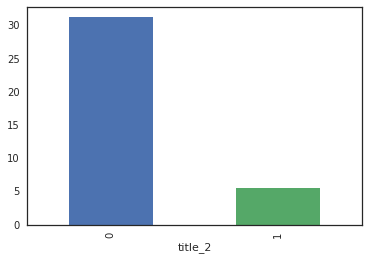

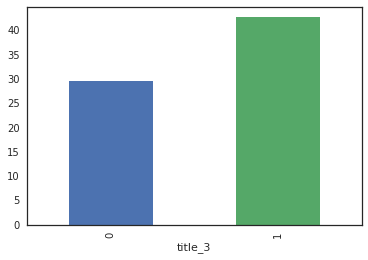

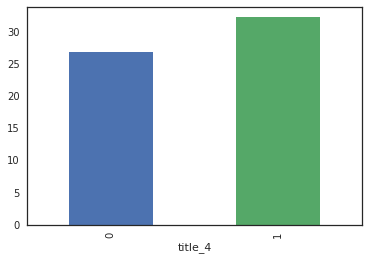

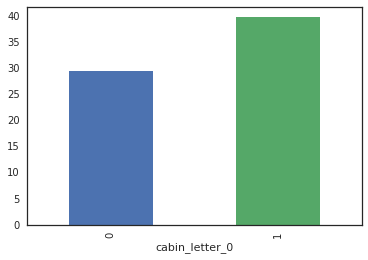

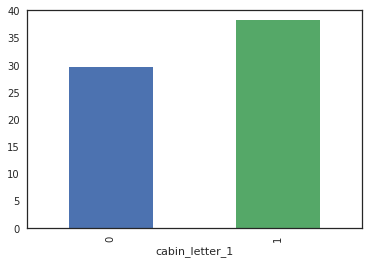

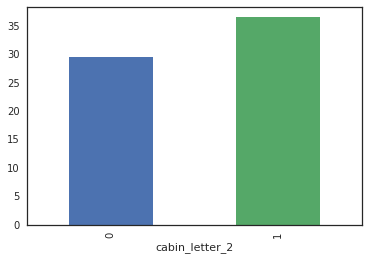

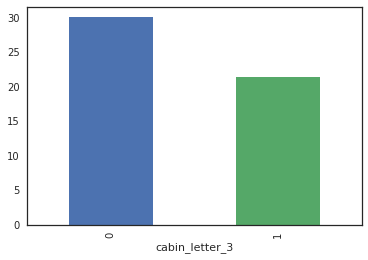

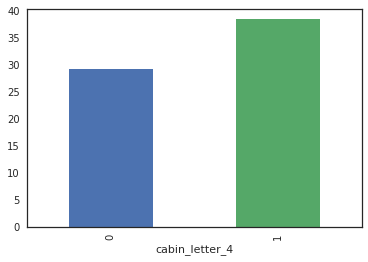

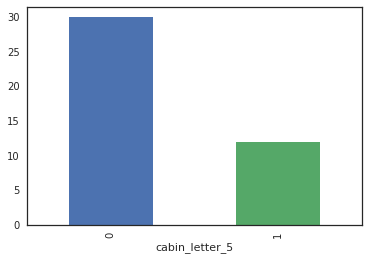

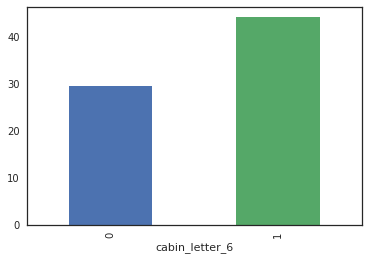

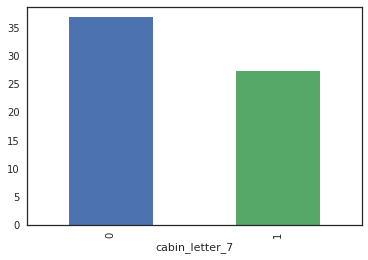

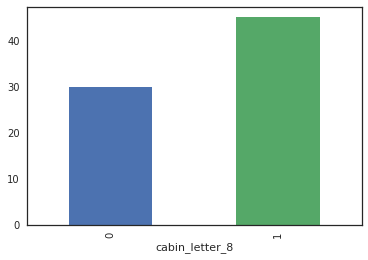

Index(['cabin_number', 'fare', 'number_parents_children', 'pclass_0',
       'title_1', 'title_2'],
      dtype='object')
Linear regression score: 0.35


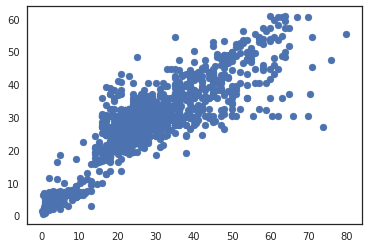

In [43]:
# no one-hots here
columns_age_regression = [
    'cabin_number',
    'family_size',
    'fare',
    'number_parents_children',
    'number_siblings_spouses',
    'sex_is_male',
    'ticket_is_digit',
    'pclass_0',
    'pclass_1',
    'pclass_2',
    'embarked_0',
    'embarked_1',
    'embarked_2',
    'title_0',
    'title_1',
    'title_2',
    'title_3',
    'title_4',
    'cabin_letter_0',
    'cabin_letter_1',
    'cabin_letter_2',
    'cabin_letter_3',
    'cabin_letter_4',
    'cabin_letter_5',
    'cabin_letter_6',
    'cabin_letter_7',
    'cabin_letter_8'
];

# regression
X_age_regression = combined_data[combined_data['age'].notnull()][columns_age_regression]
y_age_regression = combined_data[combined_data['age'].notnull()]['age']

# check mean age over columns
for column in X_age_regression.columns:
    if column != 'age':
        combined_data[combined_data['age'].notnull()].drop(['id', 'target'], axis=1).groupby(column).age.mean().plot(kind='bar', stacked=True)
        plt.show()
        
estimator_age_regression = RandomForestRegressor()

estimator_age_regression.fit(X_age_regression, y_age_regression)
feature_selection_age_regression = SelectFromModel(estimator_age_regression, prefit=True)
feature_mask_age_regression = feature_selection_age_regression.get_support(indices=True)
features_age_regression = X_age_regression.columns[feature_mask_age_regression]
X_age_regression_reduced = feature_selection_age_regression.transform(X_age_regression)
age_regression_selected_features = X_age_regression.columns[feature_mask_age_regression]

print(age_regression_selected_features)

cv_age_regression = KFold(n_splits=10, shuffle=True, random_state=0)
cv_score_age_regression = cross_val_score(estimator_age_regression, X_age_regression_reduced, y_age_regression, cv=cv_age_regression, scoring='r2').mean()

print("Linear regression score: %.2f" % cv_score_age_regression)

estimator_age_regression.fit(X_age_regression_reduced, y_age_regression)
y_pred_age_regression = estimator_age_regression.predict(X_age_regression_reduced)

plt.scatter(y_age_regression, y_pred_age_regression)
plt.show()

# replace missing age (age_bins)
missing_age_indices = combined_data['age'].isnull()
X_age_imputation = combined_data[missing_age_indices][age_regression_selected_features]
y_pred_age_imputation = estimator_age_regression.predict(X_age_imputation)
combined_data.loc[missing_age_indices, 'age'] = y_pred_age_imputation

In [44]:
# two predictions were outside bins (younger than 1 years, set to 0 with fillna)
combined_data['age_bins'] = pd.cut(combined_data['age'], age_bins, include_lowest=True, labels=False).fillna(0).astype(int)
age_bins_encoded, age_bins_onehot = encode_feature(combined_data, 'age_bins', 'target')

combined_data.drop('age_bins', axis=1)

combined_data = pd.concat([combined_data, age_bins_encoded, age_bins_onehot], axis=1) 

print(combined_data.head())
for x in combined_data.columns:
    print(x)

Empty DataFrame
Columns: [age_bins_encoded]
Index: []
    age  cabin_number  family_size     fare  id  number_parents_children  \
0  22.0        -999.0            2   7.2500   1                        0   
1  38.0          85.0            2  71.2833   2                        0   
2  26.0        -999.0            1   7.9250   3                        0   
3  35.0         123.0            2  53.1000   4                        0   
4  35.0        -999.0            1   8.0500   5                        0   

   number_siblings_spouses  sex_is_male  target  ticket_is_digit     ...      \
0                        1            1       0                0     ...       
1                        1            0       1                0     ...       
2                        0            0       1                0     ...       
3                        1            0       1                1     ...       
4                        0            1       0                1     ...       

   famil

# 3. modelling

## // prepare data

In [331]:
train_observations = combined_data['target'] != -999
test_observations = combined_data['target'] == -999

X_train = combined_data[train_observations].drop(['id', 'target'], axis=1)
y_train = combined_data[train_observations]['target']

print(X_train.shape)
print(y_train.shape)

X_test = combined_data[test_observations].drop(['id', 'target'], axis=1)

(891, 145)
(891,)


## // feature selection

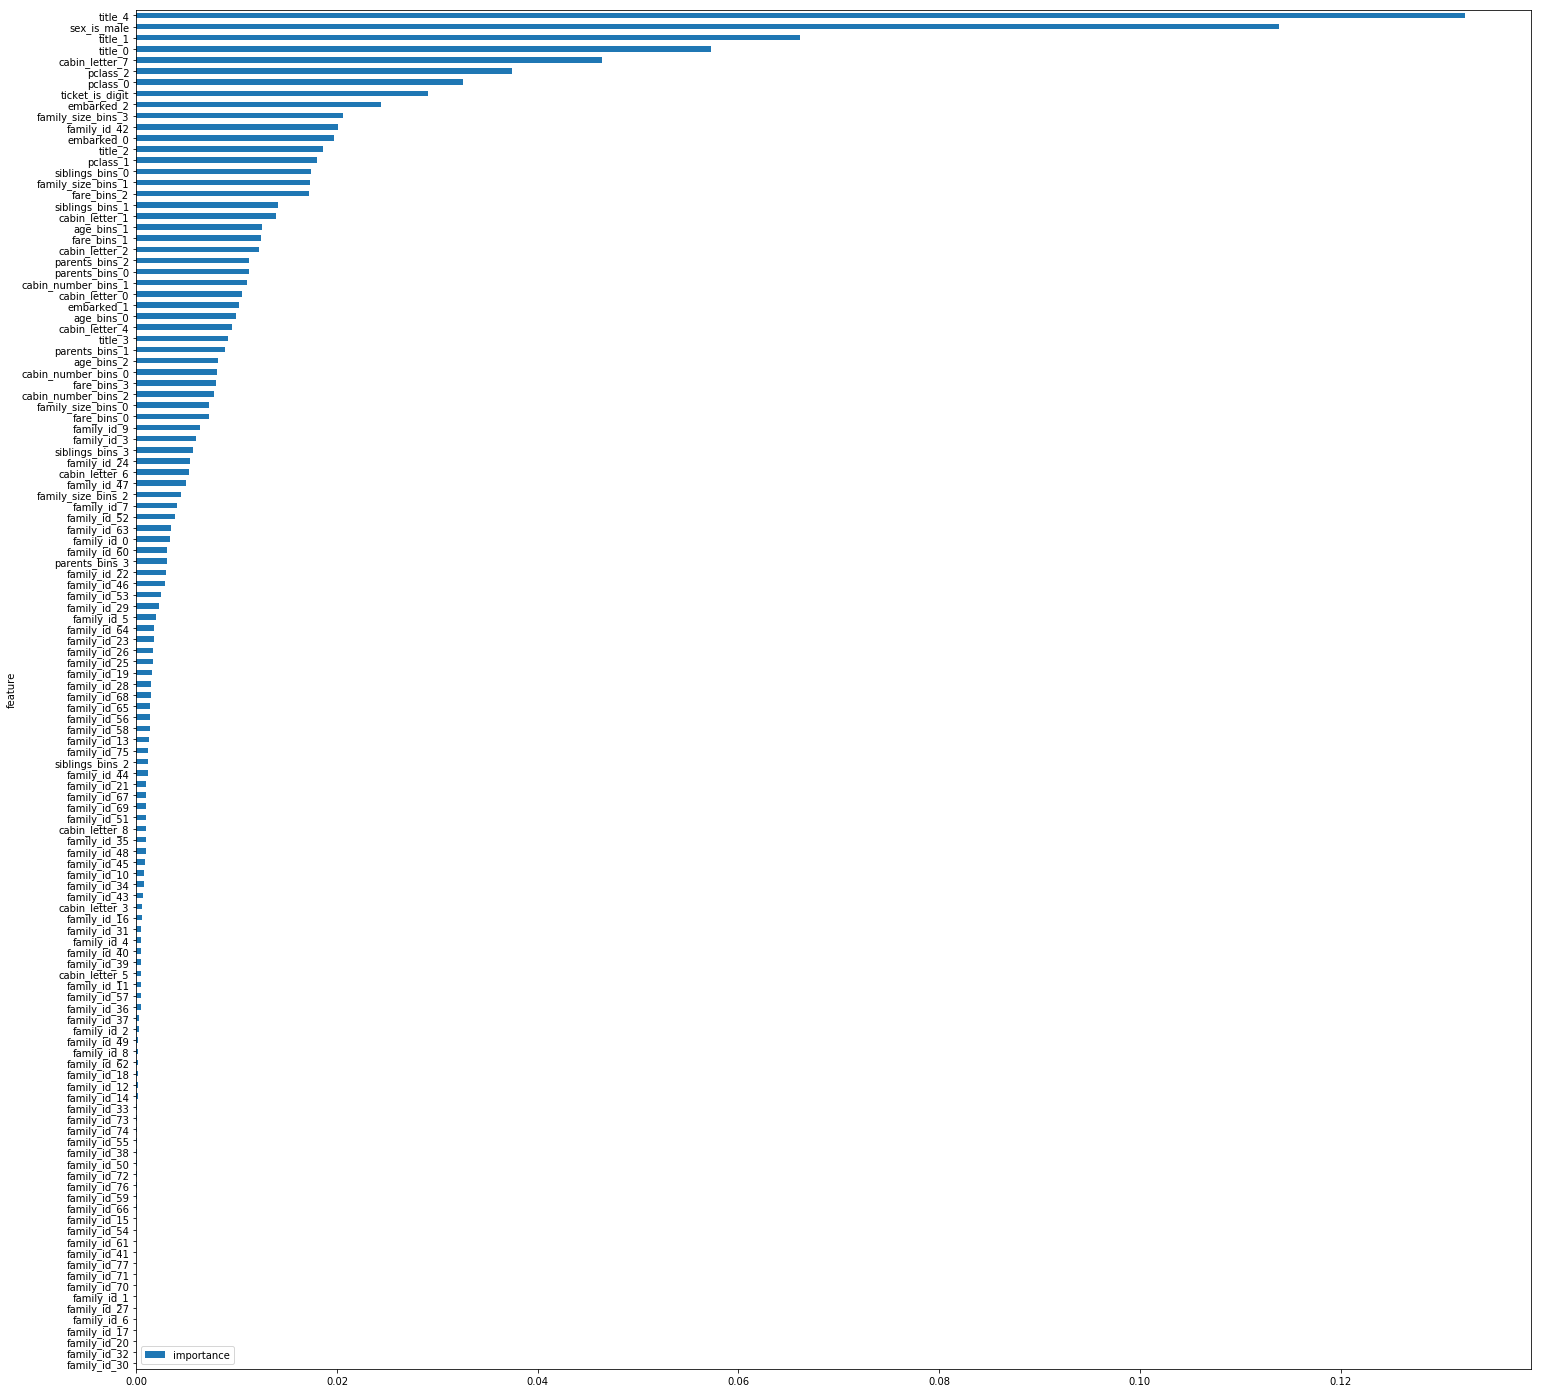

Index(['sex_is_male', 'ticket_is_digit', 'pclass_0', 'pclass_1', 'pclass_2',
       'embarked_0', 'embarked_1', 'embarked_2', 'title_0', 'title_1',
       'title_2', 'title_3', 'title_4', 'cabin_letter_0', 'cabin_letter_1',
       'cabin_letter_2', 'cabin_letter_4', 'cabin_letter_7', 'family_id_42',
       'fare_bins_1', 'fare_bins_2', 'family_size_bins_1',
       'family_size_bins_3', 'cabin_number_bins_1', 'siblings_bins_0',
       'siblings_bins_1', 'parents_bins_0', 'parents_bins_1', 'parents_bins_2',
       'age_bins_0', 'age_bins_1'],
      dtype='object')


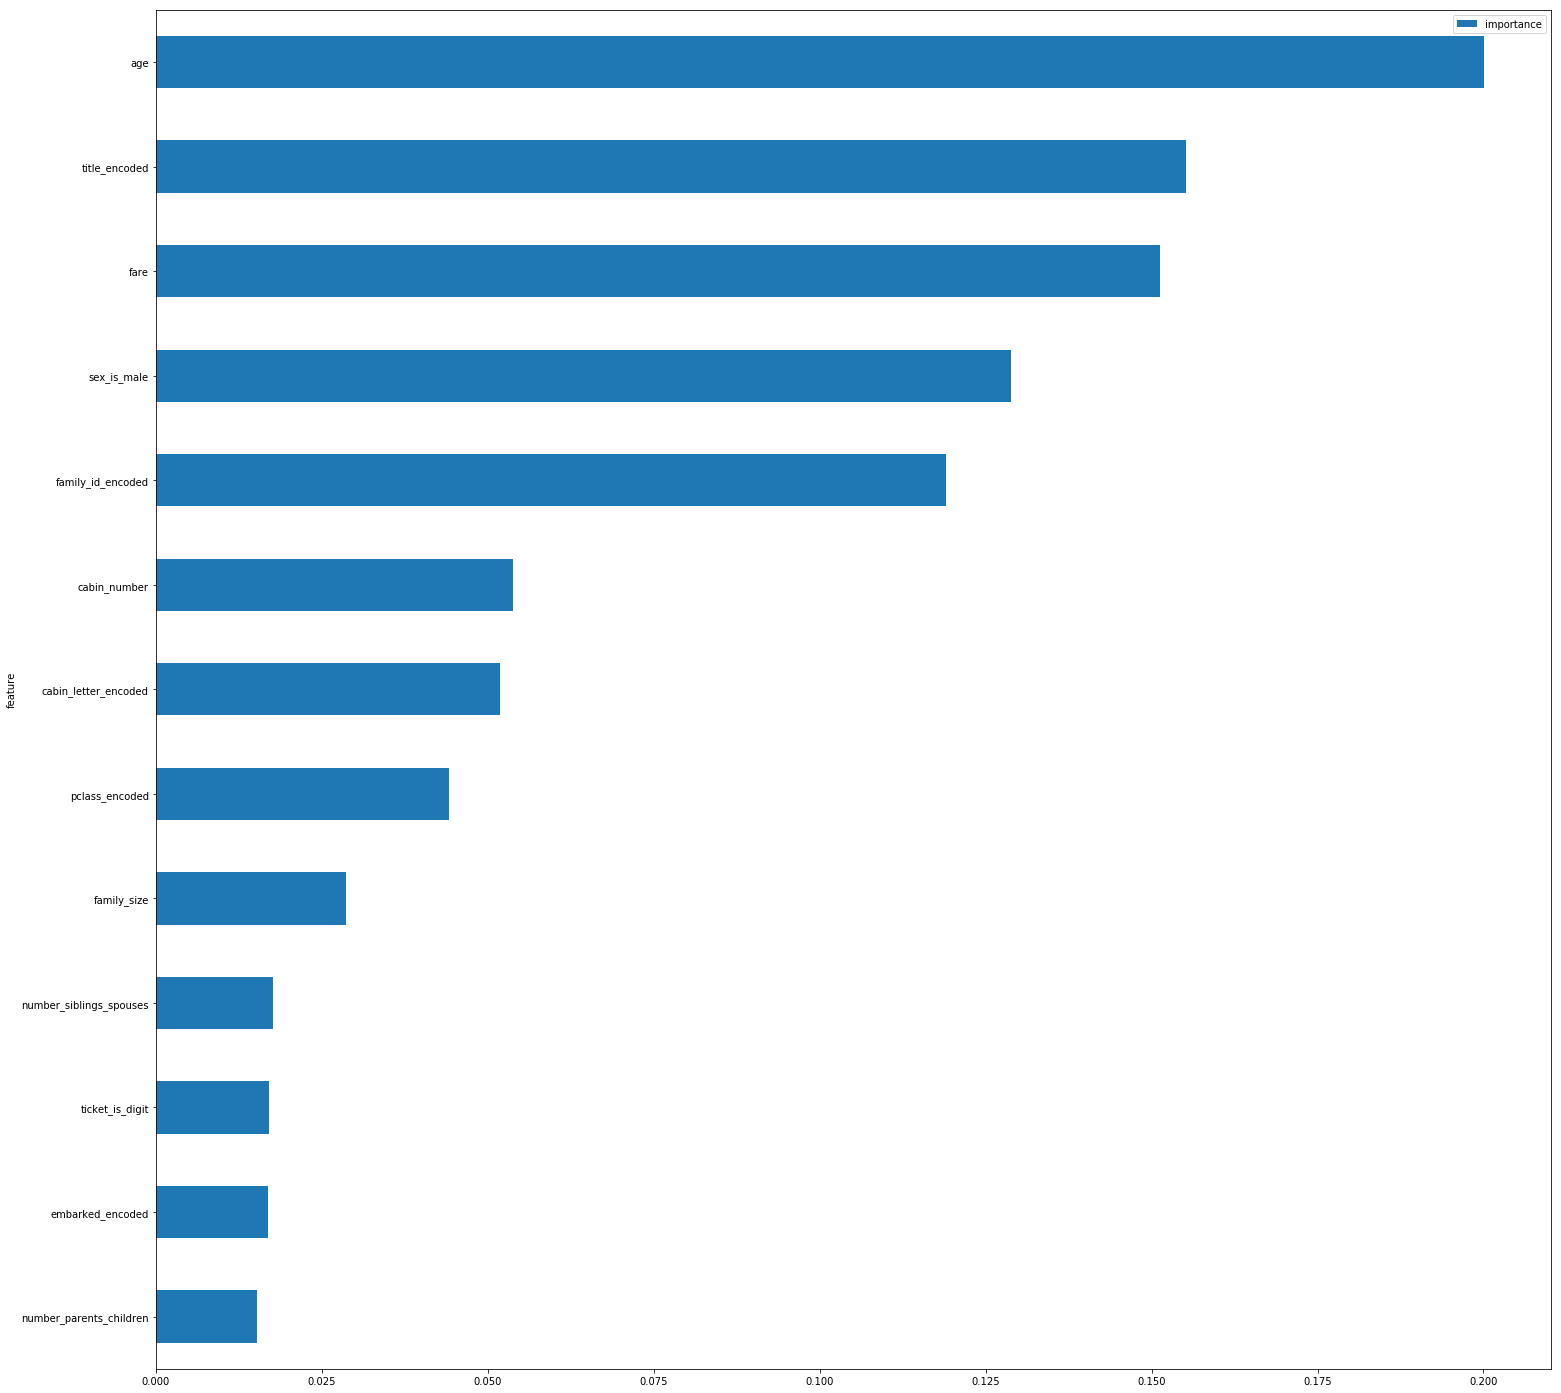

Index(['age', 'fare', 'sex_is_male', 'title_encoded', 'family_id_encoded'], dtype='object')


In [350]:
def feature_selection(X, y):

    estimator_feature_selection = RandomForestClassifier()
    estimator_feature_selection.fit(X, y)
    selection_feature_selection = SelectFromModel(estimator_feature_selection, prefit=True)
    mask_feature_selection = selection_feature_selection.get_support(indices=True)

    features = pd.DataFrame()
    features['feature'] = X.columns
    features['importance'] = estimator_feature_selection.feature_importances_
    features.sort_values(by=['importance'], ascending=True, inplace=True)
    features.set_index('feature', inplace=True)
    features.plot(kind='barh', figsize=(25, 25))

    plt.show()
    
    return X.columns[mask_feature_selection]
   
decision_tree_columns = [
    'age',
    'cabin_number',
    'family_size',
    'fare',
    'number_parents_children',
    'number_siblings_spouses',
    'sex_is_male',
    'ticket_is_digit',
    'pclass_encoded',
    'embarked_encoded',
    'title_encoded',
    'cabin_letter_encoded',
    'family_id_encoded',
]

linear_columns = [
    'sex_is_male',
    'ticket_is_digit',
    'pclass_0',
    'pclass_1',
    'pclass_2',
    'embarked_0',
    'embarked_1',
    'embarked_2',
    'title_0',
    'title_1',
    'title_2',
    'title_3',
    'title_4',
    'cabin_letter_0',
    'cabin_letter_1',
    'cabin_letter_2',
    'cabin_letter_3',
    'cabin_letter_4',
    'cabin_letter_5',
    'cabin_letter_6',
    'cabin_letter_7',
    'cabin_letter_8',
    'family_id_0',
    'family_id_1',
    'family_id_2',
    'family_id_3',
    'family_id_4',
    'family_id_5',
    'family_id_6',
    'family_id_7',
    'family_id_8',
    'family_id_9',
    'family_id_10',
    'family_id_11',
    'family_id_12',
    'family_id_13',
    'family_id_14',
    'family_id_15',
    'family_id_16',
    'family_id_17',
    'family_id_18',
    'family_id_19',
    'family_id_20',
    'family_id_21',
    'family_id_22',
    'family_id_23',
    'family_id_24',
    'family_id_25',
    'family_id_26',
    'family_id_27',
    'family_id_28',
    'family_id_29',
    'family_id_30',
    'family_id_31',
    'family_id_32',
    'family_id_33',
    'family_id_34',
    'family_id_35',
    'family_id_36',
    'family_id_37',
    'family_id_38',
    'family_id_39',
    'family_id_40',
    'family_id_41',
    'family_id_42',
    'family_id_43',
    'family_id_44',
    'family_id_45',
    'family_id_46',
    'family_id_47',
    'family_id_48',
    'family_id_49',
    'family_id_50',
    'family_id_51',
    'family_id_52',
    'family_id_53',
    'family_id_54',
    'family_id_55',
    'family_id_56',
    'family_id_57',
    'family_id_58',
    'family_id_59',
    'family_id_60',
    'family_id_61',
    'family_id_62',
    'family_id_63',
    'family_id_64',
    'family_id_65',
    'family_id_66',
    'family_id_67',
    'family_id_68',
    'family_id_69',
    'family_id_70',
    'family_id_71',
    'family_id_72',
    'family_id_73',
    'family_id_74',
    'family_id_75',
    'family_id_76',
    'family_id_77',
    'fare_bins_0',
    'fare_bins_1',
    'fare_bins_2',
    'fare_bins_3',
    'family_size_bins_0',
    'family_size_bins_1',
    'family_size_bins_2',
    'family_size_bins_3',
    'cabin_number_bins_0',
    'cabin_number_bins_1',
    'cabin_number_bins_2',
    'siblings_bins_0',
    'siblings_bins_1',
    'siblings_bins_2',
    'siblings_bins_3',
    'parents_bins_0',
    'parents_bins_1',
    'parents_bins_2',
    'parents_bins_3',
    'age_bins_0',
    'age_bins_1',
    'age_bins_2',
]

linear_columns_reduced = feature_selection(X_train[linear_columns], y_train)
print(linear_columns_reduced)
decision_tree_columns_reduced = feature_selection(X_train[decision_tree_columns], y_train)
print(decision_tree_columns_reduced)

## // model selection

In [374]:
X_train_decision_treee = X_train[decision_tree_columns_reduced]
X_train_linear = X_train[linear_columns_reduced]

test_estimators = [
    {
        'estimator': LogisticRegression(),
        'params': {
            'C' : [0.01, 0.1, 0.25, 0.5, 1]
        },
        'X': X_train_linear,
        'y': y_train
    },
    {
        'estimator': SVC(),
        'params': {
            'C' : [0.01, 0.1, 0.25, 0.5, 1]
        },
        'X': X_train_linear,
        'y': y_train
    },
    {
        'estimator': DecisionTreeClassifier(),
        'params': {
            'max_features' : range(1, len(decision_tree_columns_reduced), 1),
            'max_depth': range(1, 10, 1)
        },
        'X': X_train_decision_treee,
        'y': y_train
    },
    {
        'estimator': RandomForestClassifier(),
        'params': {
            'max_features' : range(1, len(decision_tree_columns_reduced), 1),
            'max_depth': range(1, 10, 1)
        },
        'X': X_train_decision_treee,
        'y': y_train
    },
#    {
#        'estimator': GradientBoostingClassifier(),
#        'params': {
#            'max_features' : range(1, len(decision_tree_columns_reduced), 1),
#            'max_depth': range(1, 10, 1)
#        }
#    }
]

num_trials = 10

results = pd.DataFrame()

for test_estimator in test_estimators:

    # Non_nested parameter search and scoring
    estimator = test_estimator['estimator']
    parameters = test_estimator['params']
    X = test_estimator['X']
    y = test_estimator['y']

    for j in range(num_trials):

        # Choose cross-validation techniques for the inner and outer loops
        inner_cv = KFold(n_splits=10, shuffle=True, random_state=j)
        outer_cv = KFold(n_splits=10, shuffle=True, random_state=j)

        clf = GridSearchCV(estimator=estimator, param_grid=parameters, cv=inner_cv, scoring='accuracy')
        clf.fit(X, y)

        # Nested CV with parameter optimization
        nested_score = cross_val_score(clf, X=X, y=y, cv=outer_cv, scoring='accuracy', n_jobs=12)

        data = {
            'estimator': clf.best_estimator_.__class__.__name__,
            'avg_cv_score': nested_score.mean(),
            'max_depth': clf.best_params_.get('max_depth', np.nan),
            'max_features': clf.best_params_.get('max_features', np.nan),
            'C': clf.best_params_.get('C', np.nan)
        }

        results = results.append(data, ignore_index=True)

        print(str(j) + ' // ' + clf.best_estimator_.__class__.__name__ + ' // ' + str(nested_score.mean()) + ' // ' + str(clf.best_params_))

results.groupby('estimator').mean()

SystemExit: 

/home/rasmus/miniconda3/envs/ml/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2971: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [375]:
final_estimators = [
    #('SVC', SVC(C=1)),
    #('LogisticRegression', LogisticRegression(C=0.625)),
    ('DecisionTreeClassifier', DecisionTreeClassifier(max_features=3, max_depth=7)),
    ('RandomForestClassifier', RandomForestClassifier(max_features=3, max_depth=7)),
    #('GradientBoostingClassifier', GradientBoostingClassifier(max_features=3, max_depth=7)),
]

warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)

voting_scores = []

for j in range(num_trials):
    cv = KFold(n_splits=10, shuffle=True, random_state=j)
    voting_estimator = VotingClassifier(final_estimators, voting='soft')
    score = cross_val_score(voting_estimator, X=X_train_decision_treee, y=y_train, cv=cv, scoring='accuracy', n_jobs=12)
    voting_scores.append(score.mean())

print('voting classifier cv score: {}'.format(np.asarray(voting_scores).mean()))

voting classifier cv score: 0.846350811485643


In [376]:
# submission
chosen_estimator = voting_estimator
chosen_estimator.fit(X_train_decision_treee, y_train)

X_test_decision_treee = X_test[decision_tree_columns_reduced]

predictions = chosen_estimator.predict(X_test_decision_treee)
output = pd.DataFrame(data={
    'PassengerId': combined_data[test_observations]['id'],
    'Survived': predictions.astype(int)
    })
    
output.to_csv('submissions/kaggle_titanic_submission_aurany_24jun2018.csv', index=False)

In [324]:
print(combined_data.head())
for x in combined_data.columns:
    print(x)

    age  cabin_number  family_size     fare  id  number_parents_children  \
0  22.0        -999.0            2   7.2500   1                        0   
1  38.0          85.0            2  71.2833   2                        0   
2  26.0        -999.0            1   7.9250   3                        0   
3  35.0         123.0            2  53.1000   4                        0   
4  35.0        -999.0            1   8.0500   5                        0   

   number_siblings_spouses  sex_is_male  target  ticket_is_digit     ...      \
0                        1            1       0                0     ...       
1                        1            0       1                0     ...       
2                        0            0       1                0     ...       
3                        1            0       1                1     ...       
4                        0            1       0                1     ...       

   parents_bins_encoded  parents_bins_0  parents_bins_1  paren